In [2]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   

Author: Andrew Tarzia

Date Created: 26 Mar 2018

License:

# Notebook for calculating the relative zinc ion affinity for different models of carbohydrate chains

TODO:


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

# Notes:
## Counter ion condensation
- The following equations apply up until zeta = 0.5 (where counter ion condensation occurs for Z = 2 ions) (https://doi.org/10.1016/S0378-4371(97)00229-X)
)

## pK values:
- pK values:

## Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%run ./expressions.py

In [5]:
# constants
T = 298 # [K]
KB = 1.38064852E-23 # boltzmann constant [J/K]
NA = 6.022140857E23 # avogadros number [mol-1]
e = 1.60217662E-19 # elementary charge [C]
E_r = 78.46 # relative permittivity [unit less] -- water!
E_0 = 8.854E-12 # vacuum permittivity [CV^-1m^-1]
PI = np.pi

print("============= Constants =============")
print("temperature =", T, "K")
print("kB =", KB, "J/K")
print("kBT =", KB*T*NA/1000, "kJ/mol")
print("Avogadros Number =", NA, "mol^-1")
print("elementary charge =", e, "C")
print("relative permittivity =", E_r)
print("vacuum permittivity =", E_0, "C V^-1 m^-1")
print("=====================================")

## variables ##
# salt concs (1 - Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = 2  # zinc 2+
Z2 = -1  # co-ion
# monomer length (length of Glucose unit)
Lc = 5 # angstrom
# number of monomers in carbohydrate chain
# or degree of polymerisation DP
DP = 20
# cylinder radius
# assume it is half the amount for double stranded DNA
a = 5  # angstrom
# set pH
PH = 11
# get cylinder surface area
surf_area = 2 * np.pi * a * DP*Lc + 2 * np.pi * (a ** 2)

# radial positions from surface of cylinder (angstrom)
r_ = np.linspace(a, 150, 500)

============= Constants =============
temperature = 298 K
kB = 1.38064852e-23 J/K
kBT = 2.477709038711677 kJ/mol
Avogadros Number = 6.022140857e+23 mol^-1
elementary charge = 1.60217662e-19 C
relative permittivity = 78.46
vacuum permittivity = 8.854e-12 C V^-1 m^-1


## Charge of cylinders using Henderson Hasselbach Equation
### Assumes functionaloties are the only charge centres.

In [6]:
func_colors = {"COO": 'firebrick', "NH2": 'royalblue'}

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for CH3COONa per glucose (max at 3, for 3 OH)
# vary the degree of substitution
DS = np.linspace(0.01, 0.5, 20)
func_count = DS * DP
# set the average distance between charges on cylinder
# from DS
# in angstrom
b_ = Lc / DS

# set plot colours
colour = cm.coolwarm(np.linspace(0.5, 1, len(DS)))

# set charge and pka of functionalisations
func_charges = {"COO": -1, "NH2": +1}#, "none": 0}
func_pkas = {"none": 0, "COO": 4, "NH2": 12}

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    if func == 'none':
        partial_charge = 0
    else:
        pka = func_pkas[func]
        charge = func_charges[func]
        partial_charge = calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


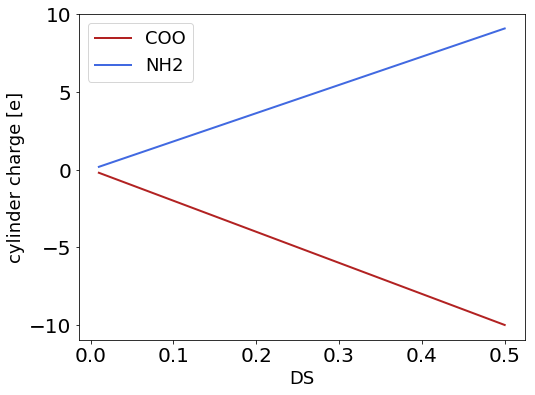

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, func_total_charges[func], label=func, c=func_colors[func], lw=2)

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("cylinder charge [e]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)
plt.show()

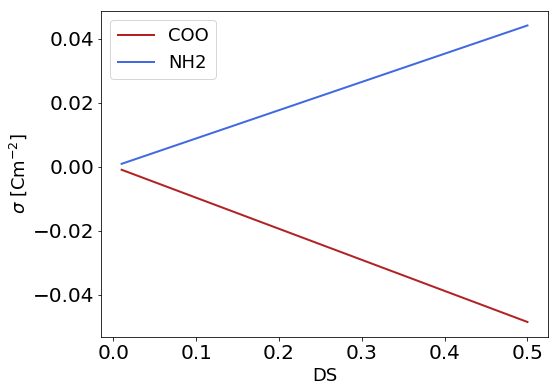

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, calculate_sigma_of_cylinder(func_total_charges[func], DP*Lc, a), label=func, c=func_colors[func], lw=2)

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)
plt.show()

#  22/4/18
## Low charge density - low salt.
Working from:
- https://arxiv.org/abs/cond-mat/9701067
- https://onlinelibrary-wiley-com.proxy.library.adelaide.edu.au/doi/abs/10.1002/bip.360230209:


In [9]:
# calculate bjerrum length
# in angstrom
print("-------------------------------")
lb = calculate_bjerrum_length(Z1)
print('lb =', lb, 'angstrom')
lb_m = lb * (10 ** -10)
print('lb =', lb_m, 'm')
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * 1000  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(lb_m, I_m)
print('kappa^2 =', kappasq, 'm^-2')
print('kappa =', np.sqrt(kappasq * (10 ** -20)), 'angstrom^-1')
print('debye length =', 1/np.sqrt(kappasq * (10 ** -20)), 'angstrom')
print("-------------------------------")
# reduced coordinates (unitless)
kr_ = np.sqrt(kappasq * (10 ** -20)) * r_

-------------------------------
lb = 7.146998626764947 angstrom
lb = 7.146998626764947e-10 m
-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 1.2980628290602427e+18 m^-2
kappa = 0.11393256027406048 angstrom^-1
debye length = 8.777122164151649 angstrom
-------------------------------


In [10]:
# only average within one Zn2+ radius
print(r_[r_ - r_[0] < 0.74])
r_[r_ - r_[0] < 0.74][1:] == r_[1:9]
_dist_slice = (1, 7)

[5.         5.29058116 5.58116232]


/home/atarzia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


=================== COO ==================
[-3.05176469e-12 -1.09221052e-11 -1.87924457e-11 -2.66627862e-11
 -3.45331267e-11 -4.24034672e-11 -5.02738077e-11 -5.81441482e-11
 -6.60144887e-11 -7.38848292e-11 -8.17551697e-11 -8.96255102e-11
 -9.74958507e-11 -1.05366191e-10 -1.13236532e-10 -1.21106872e-10
 -1.28977213e-10 -1.36847553e-10 -1.44717894e-10 -1.52588234e-10]
negatively charged cylinder
=================== NH2 ==================
[2.77433181e-12 9.92918753e-12 1.70840432e-11 2.42388990e-11
 3.13937547e-11 3.85486104e-11 4.57034661e-11 5.28583218e-11
 6.00131776e-11 6.71680333e-11 7.43228890e-11 8.14777447e-11
 8.86326004e-11 9.57874562e-11 1.02942312e-10 1.10097168e-10
 1.17252023e-10 1.24406879e-10 1.31561735e-10 1.38716590e-10]
positively charged cylinder


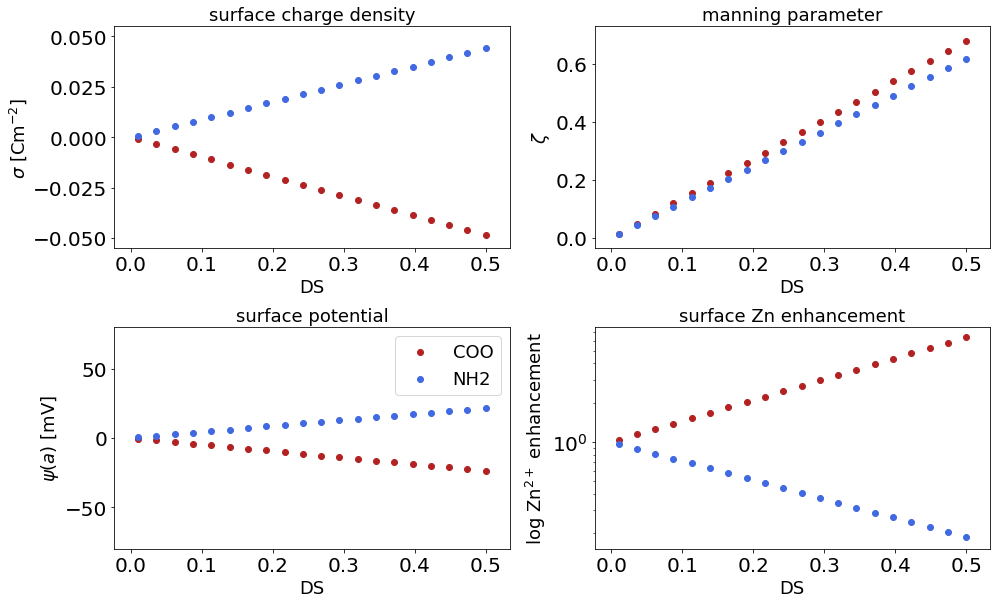

In [12]:
# iterate over funcationalities
fig = plt.figure(figsize=(14, 8.5))
ax1 = plt.subplot(221)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2 = plt.subplot(222)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3 = plt.subplot(223)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4 = plt.subplot(224)
ax4.tick_params(axis='both', which='major', labelsize=20)

func_surface_concentration = {}
for func in func_charges.keys():
    print("===================", func, "==================")
    # calculate surface charge density
    sigma = calculate_sigma_of_cylinder(func_total_charges[func], DP*Lc, a)
    ax1.scatter(DS, sigma, c=func_colors[func], label=func)
    ax1.set_title('surface charge density', fontsize=18)
    ax1.set_xlabel("DS", fontsize=18)
    ax1.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
    ax1.set_ylim(-0.055, 0.055)
    # Equation 1.4
    # line charge density lambda
    lamb = calculate_lambda(a, sigma)
    print(lamb)
    if lamb[-1] > 0:
        print("positively charged cylinder")
    elif lamb[-1] <= 0:
        print("negatively charged cylinder")
    # Equation 1.5
    zeta_ = calculate_manning_parameter(lamb, lb, Z1)
    ax2.scatter(DS, zeta_, c=func_colors[func], label=func)
    ax2.set_title('manning parameter', fontsize=18)
    ax2.set_xlabel("DS", fontsize=18)
    ax2.set_ylabel('$\zeta$', fontsize=18)
    
    # calculate reduced potential using the DH solution (https://arxiv.org/abs/cond-mat/9701067 E2.1)
    # - as a function of b (distance between charges) - multiple values used
    ys = calculate_y(zeta_, kr_, lamb)
    # calculate SI potential (psi(r))
    psi_ = []
    for i in ys:
        psi = i * KB * T / (e) #  * Z1)# Volts
        psi_.append(psi * 1000) # mV
    #for i, ds in enumerate(DS):
    #    ax3.plot(r_-r_[0], psi_[i], c=func_colors[func], label='DS = '+str(DS[i]),
    #             alpha=0.1 + (ds/3)*(0.8))
    ax3.scatter(DS, [np.average(i[_dist_slice[0]:_dist_slice[1]]) for i in psi_], c=func_colors[func], label=func)
    ax3.set_title(r'surface potential', fontsize=18)
    ax3.set_ylabel("$\psi(a)$ [mV]", fontsize=18)
    ax3.set_xlabel("DS", fontsize=18)
    #ax3.set_xlabel("distance from surface [$\AA$]", fontsize=18)
    ax3.legend(fontsize=18)
    ax3.set_ylim(-80, 80)
    # inset of potential curves
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
#    left, bottom, width, height = [0.05, 0.35, 0.1, 0.1]
#    inset = fig.add_axes([left, bottom, width, height])
#    inset.plot(r_-r_[0], psi_[-1], c=func_colors[func], label='DS = '+str(DS[-1]))
#    inset.set_ylabel("$\psi(r)$ [mV]", fontsize=18)
#    inset.set_xlabel("$r - a$ [$\AA$]", fontsize=18)
    
    
    # calculate avg concentration of zinc ions at the surface from psi(r)
    # within 1 Zinc radius 0.74 Ang from surface!
    # using boltzmann equation
    # c+/- = c+/-(bulk) * exp[-/+Z+/i*psi]
    zinc_conc = []
    zinc_counter_conc = []
    for i in psi_:   # SI
    #for i in ys:   # reduced
        surf_pot = np.average(i[_dist_slice[0]:_dist_slice[1]]) / 1000   # SI # in V
        z_c = calculate_conc(surf_pot, salt1_conc, Z1)   # SI
        z_counter_c = calculate_conc(surf_pot, salt2_conc, Z2)   # SI
        #surf_pot = np.average(i[1:5])   # reduced
        #z_c = calculate_reduced_conc(surf_pot, salt1_conc, Z1)   # reduced
        #z_counter_c = calculate_reduced_conc(surf_pot, salt2_conc, Z2)   # reduced
        zinc_conc.append(z_c)
        zinc_counter_conc.append(z_counter_c)
        
    # plot conc    
    #ax4.scatter(DS, zinc_conc, c=func_colors[func], label=func)
    #ax4.set_title('surface Zn concentration', fontsize=18)
    #ax4.set_xlabel("DS", fontsize=18)
    #ax4.set_ylabel("[Zn$^{2+}$] [M]", fontsize=18)
    #ax4.set_ylim(0, 0.1)
    func_surface_concentration[func] = zinc_conc
    # plot conc enhancement
    ax4.scatter(DS, [i/salt1_conc for i in zinc_conc], c=func_colors[func], label=func)
    ax4.set_title('surface Zn enhancement', fontsize=18)
    ax4.set_xlabel("DS", fontsize=18)
    ax4.set_ylabel("log Zn$^{2+}$ enhancement", fontsize=18)
    ax4.set_yscale("log", nonposy='clip')
    #ax4.legend(fontsize=18)
    
fig.tight_layout()
fig.savefig('cylinder_model_1.pdf', dpi=720, bbox_inches='tight')

## High charge regime (manning parameter > 1/2)

In [10]:
# constants
T = 298 # [K]
KB = 1.38064852E-23 # boltzmann constant [J/K]
NA = 6.022140857E23 # avogadros number [mol-1]
e = 1.60217662E-19 # elementary charge [C]
E_r = 78.46 # relative permittivity [unit less] -- water!
E_0 = 8.854E-12 # vacuum permittivity [CV^-1m^-1]
PI = np.pi

print("============= Constants =============")
print("temperature =", T, "K")
print("kB =", KB, "J/K")
print("kBT =", KB*T*NA/1000, "kJ/mol")
print("Avogadros Number =", NA, "mol^-1")
print("elementary charge =", e, "C")
print("relative permittivity =", E_r)
print("vacuum permittivity =", E_0, "C V^-1 m^-1")
print("=====================================")

## variables ##
# salt concs (1 - Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = 2  # zinc 2+
Z2 = -1  # co-ion
# monomer length (length of Glucose unit)
Lc = 5 # angstrom
# number of monomers in carbohydrate chain
# or degree of polymerisation DP
N = 20
# cylinder radius
# assume it is half the amount for double stranded DNA
a = 5  # angstrom
# set pH
PH = 11
# get cylinder surface area
surf_area = 2 * np.pi * a * N*Lc + 2 * np.pi * (a ** 2)

# radial positions from surface of cylinder (angstrom)
r_ = np.linspace(0, 20, 100)

# set plto colours
colour = cm.coolwarm(np.linspace(0.5, 1, len(DS)))

============= Constants =============
temperature = 298 K
kB = 1.38064852e-23 J/K
kBT = 2.477709038711677 kJ/mol
Avogadros Number = 6.022140857e+23 mol^-1
elementary charge = 1.60217662e-19 C
relative permittivity = 78.46
vacuum permittivity = 8.854e-12 C V^-1 m^-1


## Charge of cylinders using Henderson Hasselbach Equation
### Assumes functionaloties are the only charge centres.

In [18]:
func_colors = {"COO": 'r', "NH2": 'b'}

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for CH3COONa per glucose (max at 3, for 3 OH)
# vary the degree of substitution
DS = np.linspace(0.3, 3, 20)
func_count = DS * N
# set the average distance between charges on cylinder
# from DS
# in angstrom
b_ = Lc / DS

# set charge and pka of functionalisations
func_charges = {"COO": -1, "NH2": +1}#, "none": 0}
func_pkas = {"none": 0, "COO": 4, "NH2": 12}

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    if func == 'none':
        partial_charge = 0
    else:
        pka = func_pkas[func]
        charge = func_charges[func]
        partial_charge = calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


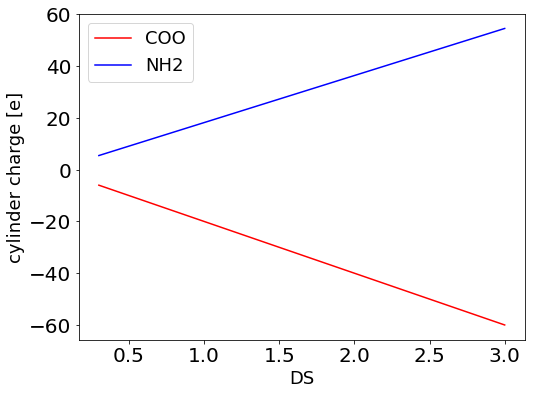

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, func_total_charges[func], label=func, c=func_colors[func])

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("cylinder charge [e]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)
plt.show()

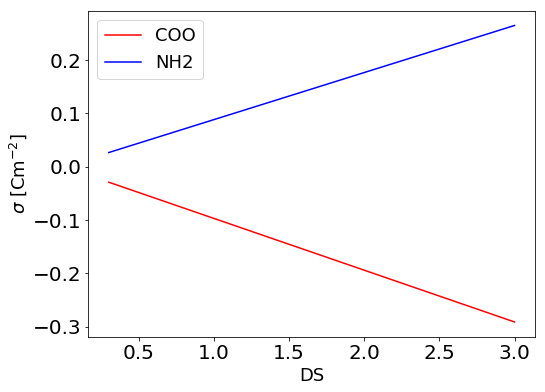

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, calculate_sigma_of_cylinder(func_total_charges[func], N*Lc, a), label=func, c=func_colors[func])

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)
plt.show()

In [21]:
# calculate bjerrum length
# in angstrom
print("-------------------------------")
lb = calculate_bjerrum_length(Z1)
print('lb =', lb, 'angstrom')
lb_m = lb * (10 ** -10)
print('lb =', lb_m, 'm')
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * 1000  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(lb_m, I_m)
print('kappa^2 =', kappasq, 'm^-2')
print('kappa =', np.sqrt(kappasq * (10 ** -20)), 'angstrom^-1')
print('debye length =', 1/np.sqrt(kappasq * (10 ** -20)), 'angstrom')
print("-------------------------------")
# reduced coordinates (unitless)
kr_ = np.sqrt(kappasq * (10 ** -20)) * r_

-------------------------------
lb = 28.587994507059786 angstrom
lb = 2.8587994507059787e-09 m
-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 5.192251316240971e+18 m^-2
kappa = 0.22786512054812097 angstrom^-1
debye length = 4.3885610820758245 angstrom
-------------------------------


=================== COO ==================
negatively charged cylinder
=================== NH2 ==================
positively charged cylinder


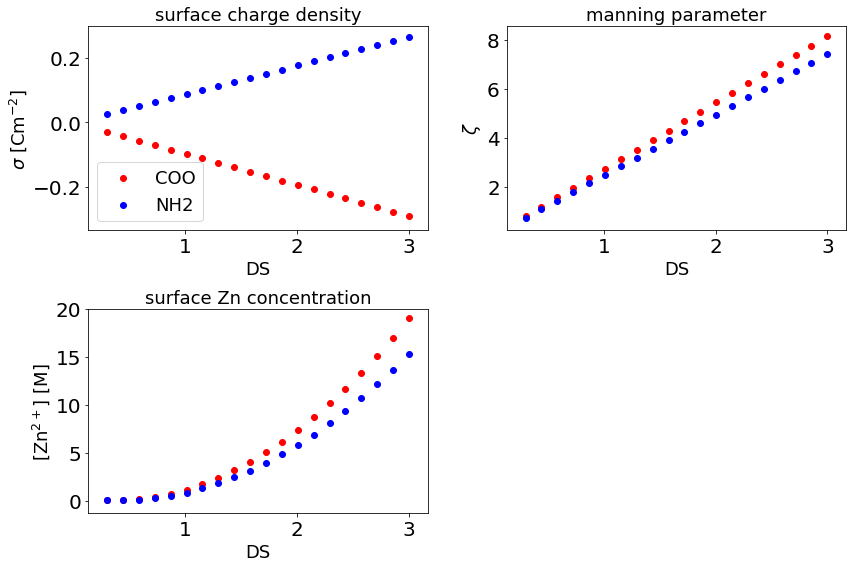

In [23]:
# iterate over funcationalities
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(221)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2 = plt.subplot(222)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3 = plt.subplot(223)
ax3.tick_params(axis='both', which='major', labelsize=20)

func_surface_concentration = {}
for func in func_charges.keys():
    print("==========================================")
    print("===================", func, "==================")
    # calculate surface charge density
    sigma = calculate_sigma_of_cylinder(func_total_charges[func], N*Lc, a)
    ax1.scatter(DS, sigma, c=func_colors[func], label=func)
    ax1.set_title('surface charge density', fontsize=18)
    ax1.set_xlabel("DS", fontsize=18)
    ax1.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
    ax1.legend(fontsize=18)
    # Equation 1.4
    # line charge density lambda
    lamb = calculate_lambda(a, sigma)
    # change defintiion of co and counter ions based on cylidner charge
    # ion valencies
    Z1 = 2  # zinc 2+
    Z2 = -1  # co-ion
    if lamb[-1] > 0:
        print("positively charged cylinder")
    elif lamb[-1] <= 0:
        print("negatively charged cylinder")
    #    Z1 = -1 * Z1
    #    Z2 = -1 * Z2
    # Equation 1.5
    zeta_ = calculate_manning_parameter(lamb, lb, Z1)
    ax2.scatter(DS, zeta_, c=func_colors[func], label=func)
    ax2.set_title('manning parameter', fontsize=18)
    ax2.set_xlabel("DS", fontsize=18)
    ax2.set_ylabel('$\zeta$', fontsize=18)
    
    # Equation 1.6
    n_plus_surface = calculate_zinc_surface_conc(zeta_, lb, a)
    
    #for i, ds in enumerate(DS):
    #    ax3.plot(r_, psi_[i], c=colour[i], label='DS = '+str(DS[i]))
    ax3.scatter(DS, n_plus_surface, c=func_colors[func], label=func)
    ax3.set_title('surface Zn concentration', fontsize=18)
    ax3.set_xlabel("DS", fontsize=18)
    ax3.set_ylabel("[Zn$^{2+}$] [M]", fontsize=18)
    
    func_surface_concentration[func] = n_plus_surface

    
    
    print("==========================================")
fig.tight_layout()
#fig.savefig('surface_conc_vs_DS.pdf', dpi=720, bbox_inches='tight')